In [2]:
!pip install optuna
!pip install catboost

In [3]:
import pandas as pd

import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import optuna
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self,train_csv,val_csv,test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df, self.test_df



    def oversample_data_with_adasyn(self, train_df):
      if train_df is not None:
        X = train_df.drop(columns=['DiagPeriodL90D'], axis=1)
        y = train_df['DiagPeriodL90D']

        adasyn = ADASYN(random_state=37)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)

        train_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['DiagPeriodL90D'])], axis=1)

        return train_df

    def get_column_info(self):
        data_types = self.train_df.dtypes
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if "patient_zip3" in numerical_cols:
          numerical_cols.remove("patient_zip3")

        if "patient_zip3" not in categorical_cols:
          categorical_cols.append("patient_zip3")
        return categorical_cols, numerical_cols

    def impute_data(self):
      _, numerical_cols = self.get_column_info()

      excluded_cols = ['Unnamed: 0', 'DiagPeriodL90D']
      cols_to_impute = [col for col in numerical_cols if col not in excluded_cols]

      num_imputer = SimpleImputer(strategy='mean')

      if self.train_df is not None:
        self.train_df[cols_to_impute] = num_imputer.fit_transform(self.train_df[cols_to_impute])

      if self.val_df is not None:
        self.val_df[cols_to_impute] = num_imputer.transform(self.val_df[cols_to_impute])
      if self.test_df is not None:
        common_cols_to_impute = [col for col in cols_to_impute if col in self.test_df.columns]
        self.test_df[common_cols_to_impute] = num_imputer.transform(self.test_df[common_cols_to_impute])

      return self.train_df, self.val_df, self.test_df


    def select_top_features(self, df):
        selected_features = [
        "patient_id", "breast_cancer_diagnosis_code", "patient_age",
        "metastatic_cancer_diagnosis_code", "payer_type", "patient_race",
        "patient_zip3", "patient_state", "income_household_25_to_35",
        "rent_burden", "income_household_under_5","DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()

        if 'patient_zip3' in continuous_cols:
          continuous_cols.remove('patient_zip3')
        if 'patient_zip3' not in categorical_cols:
          categorical_cols.append('patient_zip3')

        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, test_df, continuous_columns, columns_to_exclude):
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])
        test_df[columns_to_scale] =  scaler.transform(test_df[columns_to_scale])

        return train_df, val_df, test_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        if train_columns is not None:
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def create_and_save_folds(self, df, path, n_splits=4, train_ratio=0.8):
      fold_size = len(df) // n_splits
      for fold_number in range(n_splits):
        start_index = fold_number * fold_size
        end_index = start_index + fold_size if fold_number < n_splits - 1 else len(df)

        val_fold = df.iloc[start_index:end_index]
        train_fold = pd.concat([df.iloc[:start_index], df.iloc[end_index:]])

        train_fold, val_fold = train_test_split(train_fold, train_size=train_ratio, random_state=42)

        train_fold_filename = path + f'train_fold_{fold_number+1}.csv'
        val_fold_filename = path + f'val_fold_{fold_number+1}.csv'

        train_fold.to_csv(train_fold_filename, index=False)
        val_fold.to_csv(val_fold_filename, index=False)

        print(f'Fold {fold_number+1} written to {train_fold_filename} and {val_fold_filename}')



    def read_and_print_fold_shapes(self, path, num_folds=4):
      train_folds = []
      val_folds = []
      for fold_number in range(1, num_folds + 1):
        train_fold_filename = path + f'train_fold_{fold_number}.csv'
        val_fold_filename = path + f'val_fold_{fold_number}.csv'

        train_fold = pd.read_csv(train_fold_filename)
        val_fold = pd.read_csv(val_fold_filename)

        print(f'Fold {fold_number} Training Set Shape: {train_fold.shape}')
        print(f'Fold {fold_number} Validation Set Shape: {val_fold.shape}')

        train_folds.append(train_fold)
        val_folds.append(val_fold)

      return train_folds, val_folds

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        patient_id = df['patient_id'].values

        if target_column and target_column in df.columns:
          features = df.drop(columns=['patient_id', target_column])
          target = df[target_column]
        else:
          features = df.drop(columns=['patient_id'])
          target = None

        if target_column and target is not None:
          features, target = shuffle(features, target, random_state=42)

        return features, target, patient_id

cross_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/cross_val/'


train_val_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/imputed_values/'
test_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'

meta_obj = MetastaticDiagnosis()


train_csv = train_val_path + 'train_df.csv'
val_csv = train_val_path + 'val_df.csv'
test_csv = test_path + 'test.csv'

train_df, val_df, test_df = meta_obj.read_data(train_csv, val_csv, test_csv)
print(train_df.shape)
print(val_df.shape)



# meta_obj = MetastaticDiagnosis()

# train_csv = train_val_path + 'train_df.csv'
# val_csv = train_val_path + 'val_df.csv'
# test_csv = test_path + 'test.csv'

# train_df, val_df, test_df = meta_obj.read_data(train_csv, val_csv, test_csv)
# print(train_df.shape)
# print(val_df.shape)


# # missing_columns = set(val_df.columns) - set(train_df.columns)
# # print("Column(s) missing in train_df:", missing_columns)

# print("Train data shape :", train_df.shape, "\n")
# print("Val data shape :", val_df.shape, "\n")

# print("Test data shape:", test_df.shape, "\n")


# train_df, val_df, test_df = meta_obj.impute_data()

# missing_columns = set(val_df.columns) - set(train_df.columns)
# print("Column(s) missing in train_df:", missing_columns)
# val_df = val_df.drop(columns='predicted_patient_state')

# # missing_columns = set(test_df.columns) - set(train_df.columns)
# # print("Column(s) missing in train_df:", missing_columns)
# # test_df = test_df.drop(columns='predicted_patient_state')


# print("Train data shape after imputation:", train_df.shape)
# print("Validation data shape after imputation:", val_df.shape, "\n")
# print("Test data shape after imputation:", test_df.shape, "\n")


train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")

train_df = train_df.drop('Unnamed: 0', axis=1)
val_df = val_df.drop('Unnamed: 0', axis=1)
#test_df = test_df.drop('Unnamed: 0', axis=1)

continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")

continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled, test_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected,test_df, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape)
print("After scaling test data", test_df_scaled.shape, "\n")


train_df_encoded = meta_obj.preprocess_data(train_df_scaled, None, category_cols)





train_columns = train_df_encoded.columns.tolist()

val_df_encoded = meta_obj.preprocess_data(val_df_scaled, train_columns, category_cols)

test_df_encoded = meta_obj.preprocess_data(test_df_scaled, train_columns, category_cols)



print("Train data shape after one hot encoding: ", train_df_encoded.shape)
print("Validation data shape after one hot encoding: ", val_df_encoded.shape, "\n")
print("test_df_encoded data shape after one hot encoding: ", test_df_encoded.shape, "\n")


# Call the oversample_data function
train_df_encoded = meta_obj.oversample_data_with_adasyn(train_df_encoded)
print("Train data shape after oversampling columns:", train_df_encoded.shape, "\n")

path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/cross_val/'
filename = 'train_df_encoded.csv'
full_path = path + filename
# Write the DataFrame to a CSV file
train_df_encoded.to_csv(full_path, index=False)
print(f'Train data encoded version saved to {full_path}')


grouping_field = 'patient_id'
path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/cross_val/'

X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_encoded, 'DiagPeriodL90D', is_fit=True)

X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_encoded, 'DiagPeriodL90D', is_fit=False)

X_test, _, test_patient_id = meta_obj.preprocess_and_shuffle(test_df_encoded, target_column=None, is_fit=False)


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")



if 'DiagPeriodL90D' in X_test.columns:
    X_test = X_test.drop(columns=['DiagPeriodL90D'])

extra_columns = set(X_test.columns) - set(X_train.columns)
print(f"Extra columns in X_test: {extra_columns}")
print("X_test shape: ", X_test.shape, "\n")


(10324, 82)
(2582, 83)
Train data shape after feature selection: (10324, 12)
Validation data shape after feature selection: (2582, 12) 

Continuous columns: ['patient_id', 'patient_age', 'income_household_25_to_35', 'rent_burden', 'income_household_under_5', 'DiagPeriodL90D']
Categorical columns: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_race', 'patient_state', 'patient_zip3'] 

After scaling train data  (10324, 12)
After scaling val data (2582, 12)
After scaling test data (5792, 82) 



<ipython-input-4-e4e5fce950d9>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
<ipython-input-4-e4e5fce950d9>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])
<ipython-input-4-e4e5fce950d9>:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

Train data shape after one hot encoding:  (10324, 877)
Validation data shape after one hot encoding:  (2582, 877) 

test_df_encoded data shape after one hot encoding:  (5792, 877) 

Train data shape after oversampling columns: (13071, 877) 

Train data encoded version saved to /content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/cross_val/train_df_encoded.csv
X_train shape:  (13071, 875)
y_train shape:  (13071,)
X_val shape:  (2582, 875)
y_val shape:  (2582,) 

Extra columns in X_test: set()
X_test shape:  (5792, 875) 



train_folds <class 'list'>
val_folds <class 'list'>

Best Average AUC across all folds: 0.8720
0.7920246987797704
Training Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.96      0.75      0.84      6623
    Diagnosed within 90 Days       0.79      0.97      0.87      6448

                    accuracy                           0.86     13071
                   macro avg       0.87      0.86      0.85     13071
                weighted avg       0.87      0.86      0.85     13071



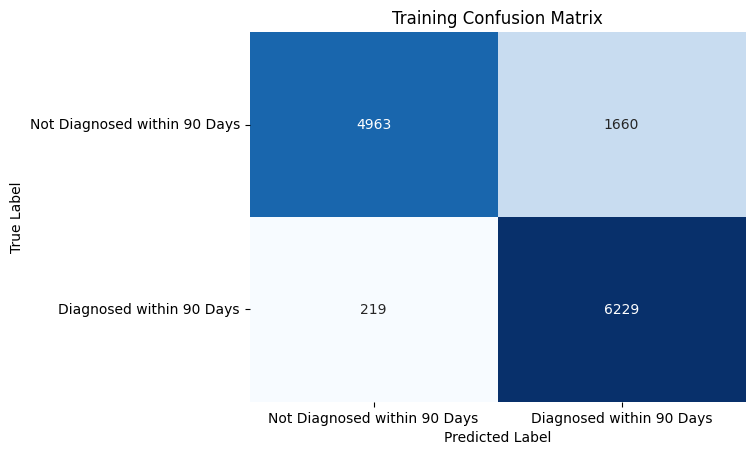

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.89      0.55      0.68       970
    Diagnosed within 90 Days       0.78      0.96      0.86      1612

                    accuracy                           0.81      2582
                   macro avg       0.84      0.76      0.77      2582
                weighted avg       0.82      0.81      0.79      2582



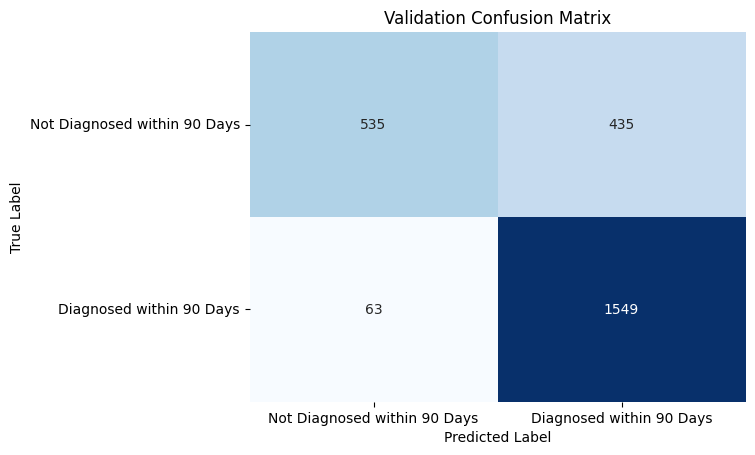


 ROC Curve


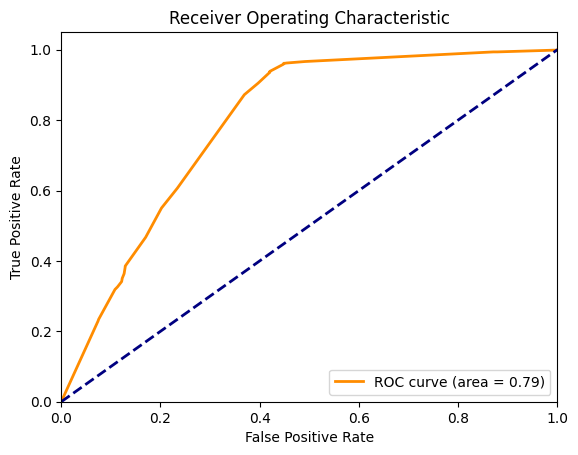

In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


class ModelBuilder:
  def __init__(self):
        self.stacking_classifier = None

  def setup_stacking_classifier(self, estimators, final_estimator, stack_method='auto', passthrough=False):
        """
        Initializes the stacking classifier with the given base estimators and final estimator.
        """
        self.stacking_classifier = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        stack_method=stack_method,
        passthrough=passthrough
    )

  def read_and_return_fold_data(self, path, num_folds=4):
    train_folds = []
    val_folds = []
    for i in range(1, num_folds + 1):
        train_fold_path = f"{path}train_fold_{i}.csv"
        val_fold_path = f"{path}val_fold_{i}.csv"

        train_fold = pd.read_csv(train_fold_path)
        val_fold = pd.read_csv(val_fold_path)

        train_folds.append(train_fold)
        val_folds.append(val_fold)

    return train_folds, val_folds

  def get_stacking_components(self):
    estimators = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('gbc', GradientBoostingClassifier(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('gnb', GaussianNB()),
        ('mlp', MLPClassifier(max_iter=1000, random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('xgb', XGBClassifier(random_state=42)),
        ('cat', CatBoostClassifier(logging_level='Silent', random_state=42)),
    ]

    final_estimator = XGBClassifier(random_state=42)

    return estimators, final_estimator


  def tune_hyperparameters(self, param_grid, train_folds, val_folds):
    best_score = -np.inf
    best_params = None

    for params in ParameterGrid(param_grid):
      estimators, final_estimator = self.get_stacking_components()

      final_estimator_params = {k.replace('final_estimator__', ''): v for k, v in params.items() if 'final_estimator__' in k}
      final_estimator.set_params(**final_estimator_params)

      stack_method = params.get('stack_method', 'auto')

      self.setup_stacking_classifier(estimators, final_estimator, stack_method=stack_method)

      auc_scores = []
      for train_df, val_df in zip(train_folds, val_folds):
        X_train, y_train = train_df.drop(columns='DiagPeriodL90D'), train_df['DiagPeriodL90D']
        X_val, y_val = val_df.drop(columns='DiagPeriodL90D'), val_df['DiagPeriodL90D']

        self.stacking_classifier.fit(X_train, y_train)
        y_pred_proba = self.stacking_classifier.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc_score)

        avg_auc = np.mean(auc_scores)

      if avg_auc > best_score:
        best_score = avg_auc
        best_params = params

      print(f"\nBest Average AUC across all folds: {best_score:.4f}")

      final_estimator.set_params(**{k.replace('final_estimator__', ''): v for k, v in best_params.items() if 'final_estimator__' in k})
      self.setup_stacking_classifier(estimators, final_estimator, stack_method=best_params.get('stack_method', 'auto'))

      return best_params, best_score


  def train_with_best_params(self, best_params, X_train, y_train, X_val, y_val):
    final_estimator_params = {k.replace('final_estimator__', ''): v for k, v in best_params.items() if 'final_estimator__' in k}

    stack_method = best_params.get('stack_method', 'auto')  # Default to 'auto' if not specified
    passthrough = best_params.get('passthrough', False)  # Default to False if not specified

    self.setup_stacking_classifier([
            ('rf', RandomForestClassifier(random_state=42)),
            ('gbc', GradientBoostingClassifier(random_state=42)),
            ('et', ExtraTreesClassifier(random_state=42)),
            ('knn', KNeighborsClassifier()),
            ('gnb', GaussianNB()),
            ('mlp', MLPClassifier(max_iter=800, random_state=42)),
            ('svc', SVC(probability=True, random_state=42)),
            ('xgb', XGBClassifier(random_state=42)),
            ('cat', CatBoostClassifier(logging_level='Silent', random_state=42)),
        ], final_estimator=XGBClassifier(**final_estimator_params),
        stack_method=stack_method,
        passthrough=passthrough
    )
    self.stacking_classifier.fit(X_train, y_train)
    preds = self.stacking_classifier.predict_proba(X_val)[:, 1]
    print(roc_auc_score(y_val, preds))

    return self.stacking_classifier

  def generate_submission(self, X_val, y_val, val_patient_id, original_val_df, result_path):
      if self.stacking_classifier is None:
        raise ValueError("Model has not been built yet.")

      val_yhat_probs_sub = self.stacking_classifier.predict_proba(X_val)
      val_yhat_probs = self.stacking_classifier.predict(X_val)

      submission = pd.DataFrame({
        'patient_id': val_patient_id,
        'DiagPeriodL90D_actual': y_val,
        'prediction': val_yhat_probs,
        'prediction_probability': val_yhat_probs_sub[:, 1],
        'breast_cancer_diagnosis_code': original_val_df['breast_cancer_diagnosis_code'],
        'patient_age': original_val_df['patient_age'],
        'metastatic_cancer_diagnosis_code': original_val_df['metastatic_cancer_diagnosis_code'],
        'patient_race': original_val_df['patient_race'],
        'patient_zip3': original_val_df['patient_zip3'],
        'patient_state': original_val_df['patient_state'],
        'payer_type': original_val_df['payer_type'],
        'income_household_25_to_35': original_val_df['income_household_25_to_35'],
        'rent_burden': original_val_df['rent_burden'],
        'income_household_under_5': original_val_df['income_household_under_5']
      })

      original_val_df.reset_index(drop=True, inplace=True)

      submission.to_csv(result_path + 'stacking_classifier.csv', index=False)

      errors_only = submission[submission['DiagPeriodL90D_actual'] != submission['prediction']]

      errors_only.to_csv(result_path + 'stacking_classifier_errors.csv', index=False)

      return submission, errors_only

  def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
    report = classification_report(y_train, train_yhat_probs, target_names=classes)
    return report

  def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
    train_cm = confusion_matrix(y_train, train_yhat_probs)
    ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.title('Training Confusion Matrix')
    plt.show()

  def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
    report = classification_report(y_val, val_yhat_probs, target_names=classes)
    return report

  def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
    val_cm = confusion_matrix(y_val, val_yhat_probs)
    ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.title('Validation Confusion Matrix')
    plt.show()

  def plot_roc_curve(self, y_true, y_scores):
    """
    Plot the Receiver Operating Characteristic (ROC) curve.

    Args:
    y_true (array-like): True binary labels.
    y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

    Returns:
    None (displays the ROC curve plot).
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

model_trainer = ModelBuilder()
path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/cross_val/'
train_folds, val_folds = model_trainer.read_and_return_fold_data(path)
print("train_folds", type(train_folds))
print("val_folds", type(val_folds))


estimators, final_estimator = model_trainer.get_stacking_components()
model_trainer.setup_stacking_classifier(estimators, final_estimator)

param_grid = {
    'final_estimator__n_estimators': [50, 100, 200],
    'final_estimator__max_depth': [3, 5, 7],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2],
    'stack_method': ['auto', 'predict_proba'],
    'passthrough': [True, False]
}
best_estimator, best_params = model_trainer.tune_hyperparameters(param_grid, train_folds, val_folds)
trained_model = model_trainer.train_with_best_params(best_estimator, X_train, y_train, X_val, y_val)
result_path = '/content/drive/MyDrive/HS/prediction/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, val_df_selected, result_path)


train_yhat_probs = trained_model.predict(X_train)
val_yhat_probs = trained_model.predict(X_val)
val_yhat_probs_sub = trained_model.predict_proba(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
y_true = y_val
y_scores = val_yhat_probs
y_scores_sub = val_yhat_probs_sub
y_scores_pos_class = val_yhat_probs_sub[:, 1]
model_trainer.plot_roc_curve(y_true, y_scores_pos_class)


In [31]:
print(best_estimator, best_params)

{'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 50, 'passthrough': True, 'stack_method': 'auto'} 0.8719675644059557
